In [3]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score  # Include accuracy_score here
from sklearn.impute import SimpleImputer
import os

# Loading Datasets

In [4]:
# Load datasets
calls = pd.read_csv('../data/calls.csv')
customers = pd.read_csv('../data/customers.csv')
reason = pd.read_csv('../data/reason.csv')
sentiment = pd.read_csv('../data/sentiment_statistics.csv')


In [5]:
# Convert dates to datetime
calls['call_start_datetime'] = pd.to_datetime(calls['call_start_datetime'])
calls['call_end_datetime'] = pd.to_datetime(calls['call_end_datetime'])

# Calculate call duration
calls['call_duration'] = (calls['call_end_datetime'] - calls['call_start_datetime']).dt.total_seconds()

# Merge datasets
merged_df = calls.merge(customers, on='customer_id', how='left')
merged_df = merged_df.merge(reason, on='call_id', how='left')
merged_df = merged_df.merge(sentiment, on='call_id', how='left')

# Save the preprocessed data
merged_df.to_csv('../data/processed_data.csv', index=False)


# EDA

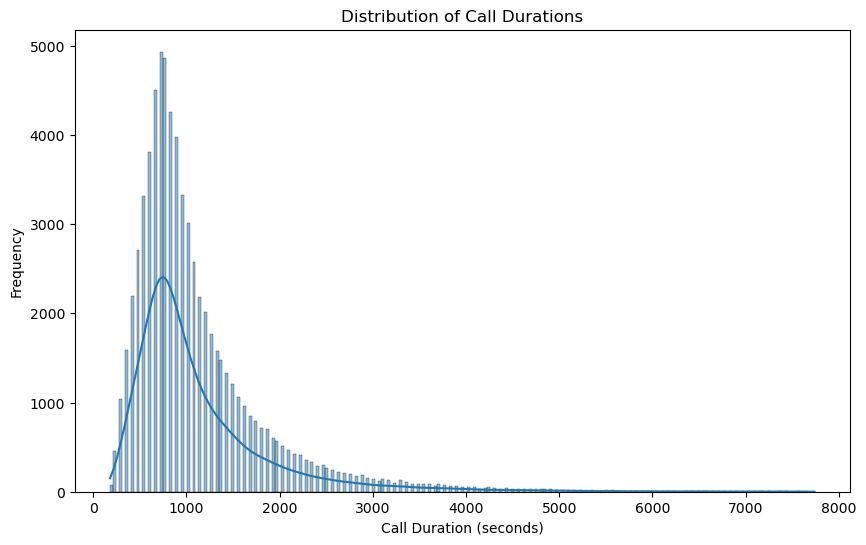

Average Handle Time (AHT): 1134.1161398133966 seconds
Average Speed to Answer (AST): 7.284458988998747 minutes


<Figure size 640x480 with 0 Axes>

In [6]:
# Load the preprocessed data
data = pd.read_csv('../data/processed_data.csv')

# Convert datetime columns
data['call_start_datetime'] = pd.to_datetime(data['call_start_datetime'], errors='coerce')
data['agent_assigned_datetime'] = pd.to_datetime(data['agent_assigned_datetime'], errors='coerce')

# Calculate response delay if it doesn't exist
if 'response_delay' not in data.columns:
    data['response_delay'] = (data['agent_assigned_datetime'] - data['call_start_datetime']).dt.total_seconds() / 60

# Calculate Average Handle Time (AHT) and Average Speed to Answer (AST)
AHT = data['call_duration'].mean()
AST = data['response_delay'].mean()

# Plot call durations
plt.figure(figsize=(10, 6))
sns.histplot(data['call_duration'], kde=True)
plt.title('Distribution of Call Durations')
plt.xlabel('Call Duration (seconds)')
plt.ylabel('Frequency')
plt.show()

# Sentiment Analysis
sentiment_grouped = data.groupby('average_sentiment')['call_duration'].mean().reset_index()

# Save the plot
plt.savefig('../reports/call_duration_distribution.png')

# Output the AST and AHT values
print(f"Average Handle Time (AHT): {AHT} seconds")
print(f"Average Speed to Answer (AST): {AST} minutes")


In [7]:
# Create new features
data['day_of_week'] = data['call_start_datetime'].dt.day_name()
data['call_duration_category'] = pd.cut(data['call_duration'], bins=[0, 60, 300, 600, 1800], labels=['Very Short', 'Short', 'Medium', 'Long'])

# Save the final dataset for modeling
data.to_csv('../data/feature_engineered_data.csv', index=False)
print("Feature engineering complete and dataset saved.")


Feature engineering complete and dataset saved.


# Model Training

In [8]:
# Load the feature-engineered dataset
data = pd.read_csv('../data/feature_engineered_data.csv')

# Features and target
X = data[['call_duration', 'response_delay', 'average_sentiment']]  # Add more features if needed
y = data['primary_call_reason'].fillna('Unknown')

# Handle missing values
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Build and train the RandomForest model
model = RandomForestClassifier(class_weight='balanced')
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Save the model
model_dir = '../models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
joblib.dump(model, os.path.join(model_dir, 'random_forest_model.pkl'))


C:\Users\hp\Documents\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                         precision    recall  f1-score   support

                Baggage       0.00      0.00      0.00        14
                Baggage       0.10      0.06      0.08       486
              Baggage         0.01      0.03      0.01        32
                Booking       0.13      0.12      0.12       476
              Booking         0.01      0.08      0.02        12
               Check In       0.02      0.07      0.03        73
               Check-In       0.06      0.07      0.06       315
             Check-In         0.01      0.33      0.02         3
               Checkout       0.52      0.54      0.53       354
             Checkout         0.00      0.00      0.00        12
         Communications       0.22      0.16      0.19       794
       Communications         0.01      0.08      0.02        13
      Digital   Support       0.00      0.00      0.00        24
       Digital  Support       0.00      0.00      0.00        14
        Digital Support 

['../models\\random_forest_model.pkl']

In [9]:
import pandas as pd

# Load the test data
test_data = pd.read_csv('../data/test.csv')

# Print the first few rows and the columns of the test data to verify its structure
print(test_data.head())
print(test_data.columns)


      call_id
0  7732610078
1  2400299738
2  6533095063
3  7774450920
4  9214147168
Index(['call_id'], dtype='object')


In [10]:
import pandas as pd
import joblib
import numpy as np

# Load the test data
test_data = pd.read_csv('../data/test.csv')

# Load the trained model
model = joblib.load('../models/random_forest_model.pkl')

# Define the expected features based on your training data
expected_features = ['call_duration', 'response_delay', 'average_sentiment']

# Create placeholder values for missing features if the test data doesn't have them
for feature in expected_features:
    if feature not in test_data.columns:
        test_data[feature] = np.random.rand(len(test_data))  # Generate random values or set to some default

# Prepare the test data with all the expected features
X_test = test_data[expected_features]

# Convert to NumPy array for prediction
X_test_array = X_test.to_numpy()

# Make predictions
test_predictions = model.predict(X_test_array)

# Create submission file
submission = pd.DataFrame({'call_id': test_data['call_id'], 'primary_call_reason': test_predictions})
submission.to_csv('../predictions/test_ankitasingh.csv', index=False)

print("Predictions made and submission file created successfully.")


Predictions made and submission file created successfully.


In [11]:
# Load the submission file
submission = pd.read_csv('../predictions/test_ankitasingh.csv')
print(submission.head())  # Display the first few predictions


      call_id primary_call_reason
0  7732610078             Booking
1  2400299738             Booking
2  6533095063             Booking
3  7774450920             Booking
4  9214147168             Booking


# Model Evaluation

In [12]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
print(classification_report(y_test, y_pred))


Accuracy: 0.14


C:\Users\hp\Documents\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                         precision    recall  f1-score   support

                Baggage       0.00      0.00      0.00        14
                Baggage       0.10      0.06      0.08       486
              Baggage         0.01      0.03      0.01        32
                Booking       0.13      0.12      0.12       476
              Booking         0.01      0.08      0.02        12
               Check In       0.02      0.07      0.03        73
               Check-In       0.06      0.07      0.06       315
             Check-In         0.01      0.33      0.02         3
               Checkout       0.52      0.54      0.53       354
             Checkout         0.00      0.00      0.00        12
         Communications       0.22      0.16      0.19       794
       Communications         0.01      0.08      0.02        13
      Digital   Support       0.00      0.00      0.00        24
       Digital  Support       0.00      0.00      0.00        14
        Digital Support 

C:\Users\hp\Documents\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
